In [1]:
from data_treat.get_ready_data import get_data
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc # метрики качества
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report # метрики качества
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from data_treat.data_normalizer import CustomNormalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns

In [2]:
COLUMNS = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price",
           "repeat_retailer","used_chip","used_pin_number","online_order", "fraud"]

In [3]:
def summ_func(x):
    print(x)
    return sum(x)

In [4]:
data = get_data()
pd.value_counts(data['fraud'])

1.0    87403
0.0    87403
Name: fraud, dtype: int64

In [5]:
data.values

array([[19.94237094, 73.47529133,  1.25309001, ...,  0.        ,
         1.        ,  1.        ],
       [ 6.89997468,  3.34378397,  2.50925105, ...,  0.        ,
         1.        ,  0.        ],
       [ 5.14830527,  0.40978415,  0.43653171, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 6.57830264,  0.11007207,  4.86389136, ...,  0.        ,
         1.        ,  1.        ],
       [55.04727753,  4.74650543,  1.3978719 , ...,  0.        ,
         1.        ,  0.        ],
       [21.10368518,  0.39048595,  2.31767665, ...,  0.        ,
         1.        ,  0.        ]])

In [6]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
93670,19.942371,73.475291,1.253090,1.0,0.0,0.0,1.0,1.0
58263,6.899975,3.343784,2.509251,1.0,0.0,0.0,1.0,0.0
34427,5.148305,0.409784,0.436532,1.0,0.0,0.0,1.0,0.0
847669,4.338614,2.780618,13.867536,1.0,0.0,0.0,1.0,1.0
363068,23.087939,1.388439,7.147438,1.0,1.0,0.0,1.0,1.0


In [7]:
target_variable_name = 'fraud'
labels = data[target_variable_name]
data = data.drop(target_variable_name, axis=1)


In [8]:
labels.head()


93670     1.0
58263     0.0
34427     0.0
847669    1.0
363068    1.0
Name: fraud, dtype: float64

In [9]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
93670,19.942371,73.475291,1.253090,1.0,0.0,0.0,1.0
58263,6.899975,3.343784,2.509251,1.0,0.0,0.0,1.0
34427,5.148305,0.409784,0.436532,1.0,0.0,0.0,1.0
847669,4.338614,2.780618,13.867536,1.0,0.0,0.0,1.0
363068,23.087939,1.388439,7.147438,1.0,1.0,0.0,1.0


In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [11]:
def model_func(x_train, x_test):
    def gridSearch(X,y):

        param_dict = {
        'n_neighbors': np.arange(1,5,1),
        }
        model = KNeighborsClassifier()
        gv = GridSearchCV(model,param_grid=param_dict)
        gv.fit(X,y)
        return gv.best_score_,gv.best_params_



    params = gridSearch(x_train, y_train)
    print(params)

    model = KNeighborsClassifier(n_neighbors=params[1]['n_neighbors'])
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)

    print("Accuracy : ",accuracy_score(y_test,predictions)*100)
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))

    test_probabilities = model.predict_proba(x_test)
    test_probabilities = test_probabilities[:, 1]
    false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

    plt.figure(figsize=(7, 7))

    # рисуем кривую
    plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

    # кривая, соответствующая случайному угадыванию
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
    plt.legend()
    plt.show()

    roc_auc_value = roc_auc_score(y_test, test_probabilities)

    print("ROC-AUC на тестовой выборке:", roc_auc_value)


    label0 = x_test[predictions==0][::900]
    label1 = x_test[predictions==1][::900]
    embedding_0 = MDS(n_components=2)
    embedding_1 = MDS(n_components=2)
    mds_0 = pd.DataFrame(embedding_0.fit_transform(label0),
                columns = ['component1','component2'])

    mds_1 = pd.DataFrame(embedding_1.fit_transform(label1),
                columns = ['component1','component2'])

    sns.scatterplot(data=mds_0,x = "component1",y="component2",color="red")
    sns.scatterplot(data=mds_1,x = "component1",y="component2",color="blue")

Для сырых данных

Для нормализованных данных

(0.9699197404371585, {'n_neighbors': 1})
Accuracy :  97.21422875567728
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     28751
         1.0       0.96      0.99      0.97     28935

    accuracy                           0.97     57686
   macro avg       0.97      0.97      0.97     57686
weighted avg       0.97      0.97      0.97     57686

[[27500  1251]
 [  356 28579]]


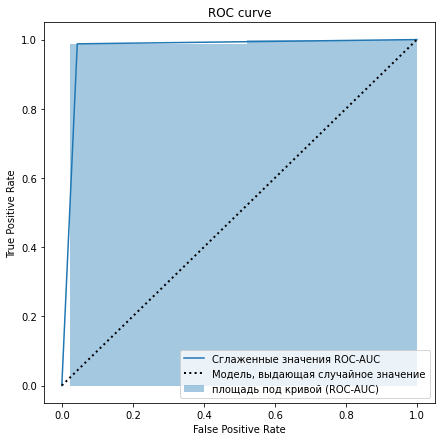

ROC-AUC на тестовой выборке: 0.9720925156121272


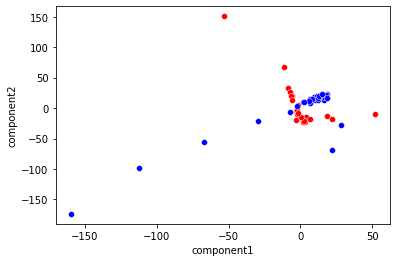

In [12]:
model_func(x_train, x_test)

Для Нормализованных данных

(0.9967725409836066, {'n_neighbors': 1})
Accuracy :  91.5057379606837
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91     28751
         1.0       0.86      1.00      0.92     28935

    accuracy                           0.92     57686
   macro avg       0.93      0.91      0.91     57686
weighted avg       0.93      0.92      0.91     57686

[[23899  4852]
 [   48 28887]]


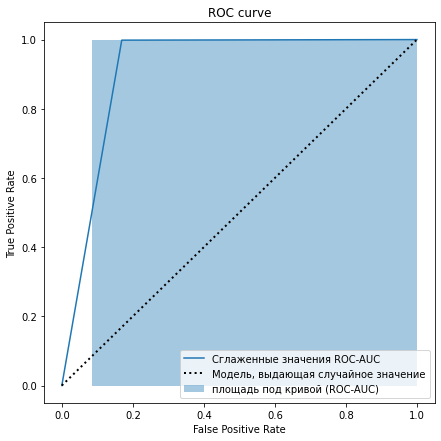

ROC-AUC на тестовой выборке: 0.9147908809410719


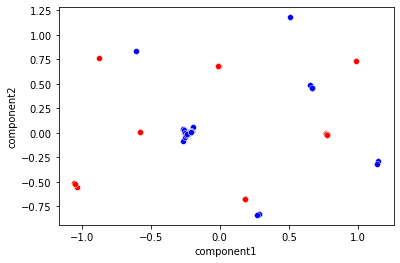

In [13]:
model_func(CustomNormalizer.normalize(x_train),CustomNormalizer.normalize(x_test))

Для стандартизированных данных


(0.9967042349726777, {'n_neighbors': 1})
Accuracy :  99.64809485837118
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     28751
         1.0       0.99      1.00      1.00     28935

    accuracy                           1.00     57686
   macro avg       1.00      1.00      1.00     57686
weighted avg       1.00      1.00      1.00     57686

[[28594   157]
 [   46 28889]]


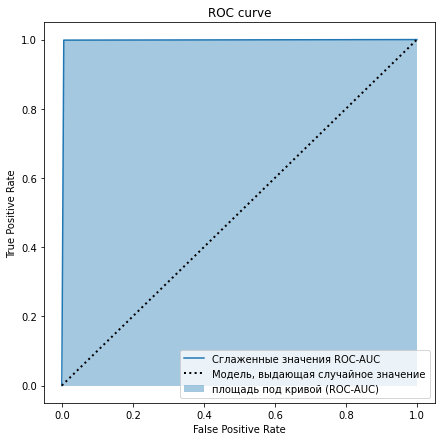

ROC-AUC на тестовой выборке: 0.9964747750984682


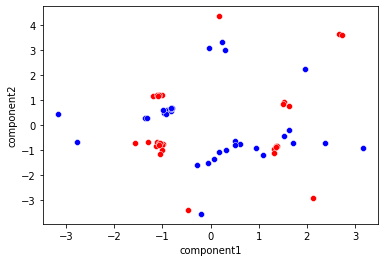

In [14]:
model_func(CustomNormalizer.standardize(x_train),CustomNormalizer.standardize(x_test))